# Full Transfer Functions

In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs
import main

from tqdm import tqdm_notebook as tqdm

# np.set_printoptions(threshold=np.nan)

Load standard solution

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

Load transfer functions for photons

In [3]:
%autoreload
highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp = main.load_trans_funcs(
    "/Users/GregoryRidgway/Downloads/"
)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons.

Generating TransferFuncInterp objects for each tflist...
Done.



Comb through ($\tau$, $m_{DM}$) space

In [45]:
end_rs = 1000

#inputs for the tau, mDM sweep
mDM = 1e4

tau = 1e21

phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                np.array([mDM/2]), 
                                highengphot_tf_interp.eng)
phot_spec_init.rs = 3000
phot_spec_init.switch_spec_type()
        
def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)
        
a = main.evolve(
    phot_spec_init*0, phot_spec_init,
    rate_func_decay_N, rate_func_decay_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
    coarsen_factor=1, std_soln=True
)

print((a[1][-1]-phys.TCMB(end_rs))/phys.TCMB(end_rs))

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),
/Users/GregoryRidgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


0.00188641095602


In [49]:
%autoreload

end_rs = 18.2

#inputs for the tau, mDM sweep
mbnds = [4,4.5]
log10mDM_arr = np.arange(mbnds[0], mbnds[1], 0.5)

taubnds = [21,21.5]
log10_tau_decay = np.arange(taubnds[0], taubnds[1], 0.5)

T_IGM_17_phot_decay_backReact = np.zeros((log10mDM_arr.size, log10_tau_decay.size))

print("Starting Loop")
#Calculating T_IGM(z=17.2) for a grid of (tau,mDM) points.
for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    for j, log10_tau in enumerate(tqdm(log10_tau_decay)):
        phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([10**log10mDM/2]), 
                                      highengphot_tf_interp.eng)
        phot_spec_init.rs = 3000
        phot_spec_init.switch_spec_type()
        
        def rate_func_decay_N(rs):
            # This is dN/dV dt
            return phys.inj_rate('decay', rs, tau=10**log10_tau)/10**log10mDM

        def rate_func_decay_eng(rs):
            # This is dN/dV dt
            return phys.inj_rate('decay', rs, tau=10**log10_tau)
        
        a = main.evolve(
            phot_spec_init*0, phot_spec_init,
            rate_func_decay_N, rate_func_decay_eng, end_rs,
            highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
            xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
            coarsen_factor=1, std_soln=True
        )
            
        b = main.evolve(
            phot_spec_init*0, phot_spec_init,
            rate_func_decay_N, rate_func_decay_eng, end_rs,
            highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
            xe_init=xe_std(phot_spec_init.rs), Tm_init=phys.TCMB(phot_spec_init.rs), 
            coarsen_factor=1, std_soln=False
        )

        T_IGM_17_phot_decay_backReact[i,j] = b[1][-1]/phys.kB
        
# pickle.dump(
#     T_IGM_17_phot_decay_backReact, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_backReact_NFW_no_subs_source.dat','wb')
# )

rs_vec = b[3].rs

Starting Loop


A Jupyter Widget

A Jupyter Widget

../darkhistory/spec/spectrum.py:758: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:663: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),
/Users/GregoryRidgway/anaconda3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [50]:
print("DarkHistory Backreaction: ", T_IGM_17_phot_decay_backReact[0,0])
print("DarkHistory no Backreaction: ", a[1][-1]/phys.kB)
T_IGM_17_phot_decay_std = pickle.load(open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_source.dat','rb'))
print("Old results old 21cm notebook, Additional Sources.ipynb: ", T_IGM_17_phot_decay_std[0,0])

DarkHistory Backreaction:  128622.736236
DarkHistory no Backreaction:  5633.18316181
Old results old 21cm notebook, Additional Sources.ipynb:  241682.368757


In [128]:
%autoreload

end_rs = 18.2

mbnds = [4,11.5]
log10mDM_arr = np.arange(mbnds[0], mbnds[1], 0.5)

taubnds = [21,30]
log10_tau_decay = np.arange(taubnds[0], taubnds[1], 0.5)

T_IGM_17_phot_decay_backReact = np.zeros((log10mDM_arr.size, log10_tau_decay.size))


#Calculating T_IGM(z=17.2) for a grid of (tau,mDM) points.
for i, log10mDM in enumerate(tqdm(log10mDM_arr)):
    for j, log10_tau in enumerate(tqdm(log10_tau_decay)):
        mDM = 10**log10mDM
        Einj = mDM/2
        Ecom=mDM
        
        phot_spec_init.rs = 3000
        
        Etmp = photeng[photeng < Einj][-1]
        phot_spec_init = spectools.rebin_N_arr(
            np.array([2*Einj/Etmp]),
            np.array([Etmp]),
            photeng
        )
        phot_spec_init.rs = 3000
        phot_spec_init.switch_spec_type()
        
        elec_spec_init = Spectrum(eleceng,
                                 np.zeros_like(eleceng),
                                 spec_type='N',
                                 rs=3000)
        
        def rate_func_N(rs):
            return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)/Ecom
        def rate_func_eng(rs):
            return phys.inj_rate(inj_type, rs, mDM=mDM, sigmav=sigmav, tau=tau)*struct_boost(rs)
        
        a = main.evolve(
        elec_spec_init, phot_spec_init,
        rate_func_N, rate_func_eng, end_rs,
        highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
        highengdep_interp, CMB_engloss_interp,
        ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
        coarsen_factor=1, std_soln=True,
        reion_switch=False,
        struct_boost=None,
        ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
        xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
        use_tqdm=True
        )

        b = main.evolve(
            elec_spec_init, phot_spec_init,
            rate_func_N, rate_func_eng, end_rs,
            highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
            highengdep_interp, CMB_engloss_interp,
            ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,
            coarsen_factor=1, std_soln=False,
            reion_switch=False,
            struct_boost=None,
            ics_only=False, separate_higheng=True, CMB_subtracted=CMB_subtracted,
            xH_func=xe_idl_func, xHe_func=xHe_idl_func, user=None, verbose=False, 
            use_tqdm=True
        )

        T_IGM_17_phot_decay_std[i,j] = a[1][-1]/phys.kB
        T_IGM_17_phot_decay_backReact[i,j] = b[1][-1]/phys.kB
        
pickle.dump(
    T_IGM_17_phot_decay_std, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','wb')
    open('/Users/GregoryRidgway/Desktop/T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','wb')
)
        
pickle.dump(
    T_IGM_17_phot_decay_backReact, 
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_backReact_NFW_no_subs_source.dat','wb')
    open('/Users/GregoryRidgway/Desktop/T_IGM_17_phot_decay_backReact_NFW_no_subs_source.dat','wb')
)

rs_vec = b[3].rs


start to evolve
rs, fs:  2994.005996001995   [5.010253871064946e-06, 3.139708532323484e-05, 0.0002113287238244386, 2.6324947675953802e-18, 0.002632474604939014]
rs, fs:  2988.023968031968   [2.0911031212181267e-05, 0.00011400683398819265, 0.0006591080663632204, 8.31465202515223e-18, 0.008314585865768418]
rs, fs:  2982.053892161797   [4.3113566113991716e-05, 0.00021772541128304762, 0.0011326374444918987, 1.4426114020448714e-17, 0.014425994774152791]


../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
../darkhistory/spec/spectrum.py:662: RuntimeWarning: divide by zero encountered in log
  np.log(bound_arr),


rs, fs:  2976.095744511174   [6.995630529748119e-05, 0.00033668626888452456, 0.0016229273624116104, 2.0844959714827655e-17, 0.02084478078346178]
rs, fs:  2970.149501247497   [0.00010017927491325333, 0.0004664165507982195, 0.002123144617948969, 2.7496366674205697e-17, 0.027496121629245987]
rs, fs:  2964.215138585785   [0.0001328065141706632, 0.0006034624394151668, 0.002628045542201953, 3.4330210546906635e-17, 0.03432989295674459]
rs, fs:  2958.29263278858   [0.00016707148202139377, 0.0007451358774270877, 0.0031335852289433603, 4.130976494437962e-17, 0.041309368279188616]
rs, fs:  2952.38196016585   [0.00020236693922506726, 0.0008893355428200465, 0.003636637536537389, 4.8405958937941095e-17, 0.04840547651436769]
start to evolve
rs, fs:  2994.005996001995   [5.010253871064946e-06, 3.139708532323484e-05, 0.0002113287238244386, 2.6324746119861177e-18, 0.002632474604939014]
rs, fs:  2988.023968031968   [2.0911031212181267e-05, 0.00011400683398819265, 0.0006591080663632204, 8.314649672411521e

In [ ]:
#injection energy, DM mass, center-of-mass energy
    
        
        
    
    
    data[i] = (a,b)

    diff_list[i] = (1-b[1]/a[1]) * 100

What was computed before using `21cm_pwave/TLA_code/examples/old_notebooks/Additional_Sources.ipynb`

In [18]:
log10mDM_arr = np.arange(4, 12.5, 0.5)
log10_tau_decay = np.arange(21, 30, 0.25)
T_IGM_17_phot_decay = pickle.load(open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/T_IGM_17_phot_decay_source.dat','rb'))

T_IGM_arr = np.arange(7.1, 50.+0.1, 0.1)
log10tau_phot_decay_arr = np.zeros((log10mDM_arr.size, T_IGM_arr.size))

for i,log10mDM in enumerate(log10mDM_arr):
    tau_interp = interp1d(
        T_IGM_17_phot_decay[i,:], log10_tau_decay, 
        bounds_error = False,
        fill_value = (100, 0)
                         )
    log10tau_phot_decay_arr[i,:] = tau_interp(T_IGM_arr)

log10tau_phot_decay_old = interp2d(log10mDM_arr, T_IGM_arr, np.transpose(log10tau_phot_decay_arr), kind='cubic')

DarkHistory (with Backreaction)

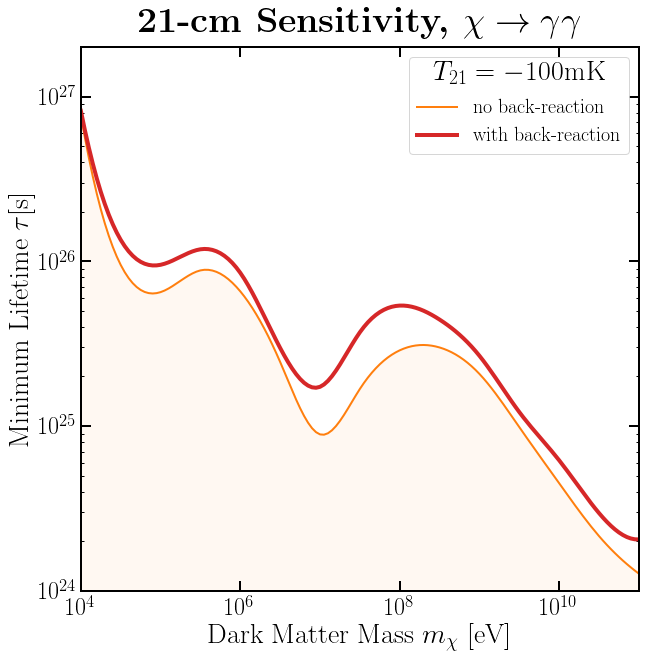

In [67]:
T_21 = -.1

#Specify grid of mDM and tau
mbnds = [4,11.5]
log10mDM_arr = np.arange(mbnds[0], mbnds[1], 0.5)
taubnds = [23,28]
log10_tau_decay = np.arange(taubnds[0], taubnds[1], 0.5)

## Load T(z=17.2) data, with and without backreaction
# T_IGM_17_phot_decay_std = pickle.load(
#     open('/Users/GregoryRidgway/Downloads/21cm_pwave/TLA_code/data/'+
#          'T_IGM_17_phot_decay_std_NFW_no_subs_source.dat','rb')
# )

T_IGM_17_phot_decay_backReact = pickle.load(
    open('/Users/GregoryRidgway/Downloads/T_IGM_17_phot_decay_backReact.dat','rb')
)

T_IGM_arr = np.arange(7.1, 50.+0.1, 0.1)
log10tau_phot_decay_arr_backReact = np.zeros((log10mDM_arr.size, T_IGM_arr.size))
# log10tau_phot_decay_arr_std = np.zeros((log10mDM_arr.size, T_IGM_arr.size))

for i,log10mDM in enumerate(log10mDM_arr):
    tau_interp_backReact = interp1d(
        T_IGM_17_phot_decay_backReact[i,:], log10_tau_decay, 
        bounds_error = False,
        fill_value = (-50, 100)
    )
    log10tau_phot_decay_arr_backReact[i,:] = tau_interp_backReact(T_IGM_arr)
    
#     tau_interp_std = interp1d(
#         T_IGM_17_phot_decay_std[i,:], log10_tau_decay, 
#         bounds_error = False,
#         fill_value = (-50, 100)
#     )
#     log10tau_phot_decay_arr_std[i,:] = tau_interp_std(T_IGM_arr)
    
log10tau_phot_decay_backReact = interp2d(log10mDM_arr, T_IGM_arr, 
                                  np.transpose(log10tau_phot_decay_arr_backReact), kind='cubic')
# log10tau_phot_decay_std = interp2d(log10mDM_arr, T_IGM_arr, 
#                                   np.transpose(log10tau_phot_decay_arr_std), kind='cubic')


log10mDM_arr_fine = np.log10(10**np.arange(mbnds[0], mbnds[1], 0.05))

plt.figure()

ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

tmp_xe=0
num = np.sqrt(.15/10/phys.omega_m)*(phys.omega_baryon*phys.h/.02)*23*.001
one_minus_ratio = T_21 / num / (1-tmp_xe) / np.sqrt(1+17.2)
temp_dat = 1-one_minus_ratio
T_m = phys.TCMB(17.2)/temp_dat/phys.kB
# T_m = 10.5

plt_old, = plt.plot(10**log10mDM_arr_fine, 
                  (10**log10tau_phot_decay_old(log10mDM_arr_fine,T_m))
                  , linewidth=2, label='no back-reaction', color='C1')
# plt.text()

ax.fill_between(
    10**log10mDM_arr_fine, 
    1e23, 
    (10**log10tau_phot_decay_old(log10mDM_arr_fine,T_m)), 
    interpolate=True, 
    color='C1',
    alpha=.05
)



# plt_std, = plt.plot(10**log10mDM_arr_fine, 
#                   (10**log10tau_phot_decay_std(log10mDM_arr_fine,T_m))
#                   , linewidth=2, label='No Backreaction')

plt_backReact, = plt.plot(10**log10mDM_arr_fine, 
                  (10**log10tau_phot_decay_backReact(log10mDM_arr_fine,T_m))
                  , linewidth=4, label='with back-reaction', color='C3')



# plt_D, = plt.plot(ms_D, sigs_D, 'k', linewidth=2, label='Diamanti et. al., 1308.2578')

leg = plt.legend(handles=[plt_old, plt_backReact],
                 fontsize=20,
          title='$T_{21} = -100$mK')
plt.setp(leg.get_title(), fontsize=28)


ymin = 1e24
ymax = 2e27

xmin = 1e4
xmax = 1e11

plt.title(r'\bf{21-cm Sensitivity,} $\chi \to \gamma \gamma$')
plt.xlabel(r'Dark Matter Mass $m_\chi$ [eV]')
plt.ylabel(r'Minimum Lifetime $\tau [\mathrm{ s}]$')
# plt.axis([xmin, xmax, ymin, ymax])
plt.axis([xmin, xmax, ymin, ymax])

plt.savefig('/Users/GregoryRidgway/Desktop/DarkHistory_21cm_Sensitivity_Decay.pdf')